# Домашнее задание 5
В этом задании мы:

1. Построим U-Net для датасета VOC segmentation, посмотрим на качество семантической сегментации.
2. Соберем GAN для генерации картинок из MNIST.
3. Прикрутим к этому GAN обуславливание на метку класса, посмотрим на результат.

In [1]:
# В терминале или в начале Jupyter:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [15]:
import typing as tp
from functools import reduce
from pathlib import Path

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
from albumentations.pytorch.transforms import ToTensorV2
from IPython.display import clear_output, display
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets import VOCSegmentation
import wandb
import torch.optim as optim
# from functools import partial

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print()

Using device: cuda



In [ ]:
wandb.init(
    project="DL_course", 
    group="lesson_5",
    config={
    "learning_rate": 0.0002,
    "architecture": "U-Net",
    "dataset": "VOCSegmentation",
    "batch_size": 8,
    "epochs": 10,  # Теперь будет ограничено Early Stopping
    "patience": 3,   # Сколько эпох ждать без улучшений
    "min_delta": 0.001  # Минимальное улучшение, чтобы считать его значимым
})
config = wandb.config

wandb: Currently logged in as: apoctol (apoctol-sber) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## U-Net на датасете VOC

Датасет [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/) - один из классических датасетов для задачи семантической сегментации.
Его используют в статьях и [по сей день](https://paperswithcode.com/dataset/pascal-voc) для бенчмарков.

В этом задании вам нужно скачать этот датасет, разбить на train и validation части, и обучить на нем U-Net.
Код для U-Net разбирался в семинаре.

В ЛМС необходимо сдать вашу реализацию U-Net и `model.pt` файл обученной модели.
Чтобы сдать это задание, модель должна достигать accuracy > 50% на тестовом датасете.

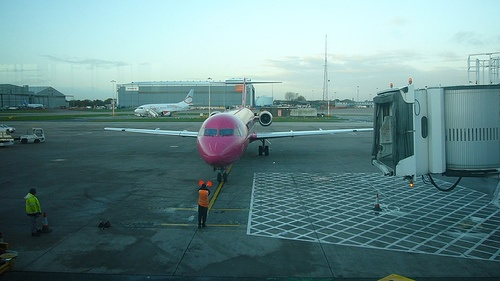

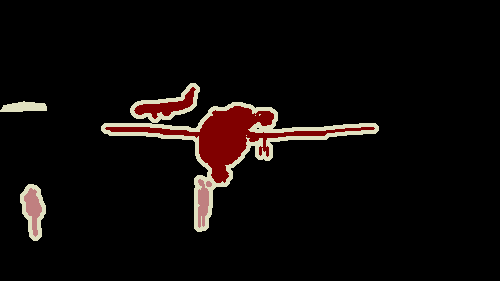

In [5]:
# Для начала загрузим датасет и посмотрим на его структуру
dataset = VOCSegmentation(
    root="./data",
    year="2012",
    image_set="train",
    download=not Path("./data").exists(),
)
display(dataset[0][0])
display(dataset[0][1])

В датасете маске присваивается 255 для границы объекта, а внутри объекта присваивается число от 0 до 20 - метка класса.

In [6]:
# Пройдемся по всем маскам датасета и возьмем уникальные значения в пикселях
reduce(
    lambda s1, s2: s1.union(s2),
    (set(np.unique(np.array(dataset[i][1])).tolist()) for i in range(len(dataset))),
    set(),
)
# Ага, действительно, метки классов от 0 до 20, при этом 0 означает "ничего интересного нет", а 255 означает границу

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 255}

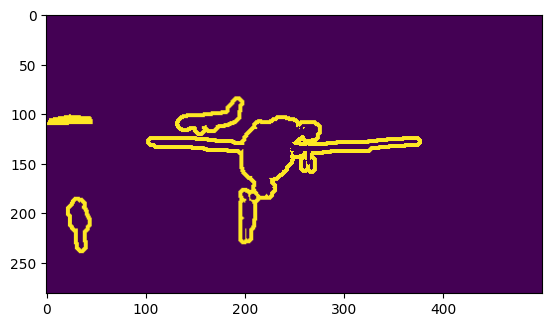

In [7]:
# Отрисуем только пиксели со значением 255 и убедимся, что они соответствуют границам объектов
plt.imshow(np.where(np.array(dataset[0][1]) == 255, 1, 0))

In [16]:
from transforms import preprocess_image, preprocess_mask, apply_transforms

In [17]:
def load_voc_dataset(split: tp.Literal["train", "val", "test"]):
    transforms = A.Compose([
        A.Resize(img_size, img_size, interpolation=cv2.INTER_NEAREST),
        A.Lambda(image=preprocess_image, mask=preprocess_mask),
        ToTensorV2()
    ])

    transform_func = partial(apply_transforms, transforms=transforms)

    dataset = VOCSegmentation(
        root="./data",
        year="2012",
        image_set=split,
        download=not Path("./data").exists(),
        transforms=transform_func
    )
    return dataset

train_dataset = load_voc_dataset("train")
val_dataset = load_voc_dataset("val")

d:\python\DL_NLP_Course\.venv\Lib\site-packages\albumentations\augmentations\transforms.py:1803: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn(
C:\Users\apoct\AppData\Local\Temp\ipykernel_4496\1203194836.py:55: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show();


(tensor([[[0.5137, 0.5137, 0.5216,  ..., 0.7176, 0.7137, 0.7137],
         [0.5176, 0.5176, 0.5255,  ..., 0.7216, 0.7176, 0.7176],
         [0.5216, 0.5216, 0.5255,  ..., 0.7216, 0.7176, 0.7176],
         ...,
         [0.0392, 0.0314, 0.0431,  ..., 0.0235, 0.0353, 0.0314],
         [0.0235, 0.0196, 0.0353,  ..., 0.0549, 0.0588, 0.0627],
         [0.0196, 0.0353, 0.0431,  ..., 0.0667, 0.0588, 0.0667]],

        [[0.7569, 0.7569, 0.7647,  ..., 0.9137, 0.9098, 0.9098],
         [0.7608, 0.7608, 0.7686,  ..., 0.9176, 0.9137, 0.9137],
         [0.7647, 0.7647, 0.7686,  ..., 0.9176, 0.9137, 0.9137],
         ...,
         [0.0627, 0.0549, 0.0588,  ..., 0.0980, 0.1059, 0.1059],
         [0.0588, 0.0549, 0.0549,  ..., 0.1294, 0.1294, 0.1333],
         [0.0549, 0.0706, 0.0627,  ..., 0.1412, 0.1294, 0.1373]],

        [[0.8157, 0.8157, 0.8235,  ..., 0.9412, 0.9451, 0.9451],
         [0.8196, 0.8196, 0.8275,  ..., 0.9451, 0.9490, 0.9490],
         [0.8235, 0.8235, 0.8275,  ..., 0.9451, 0.9490, 0

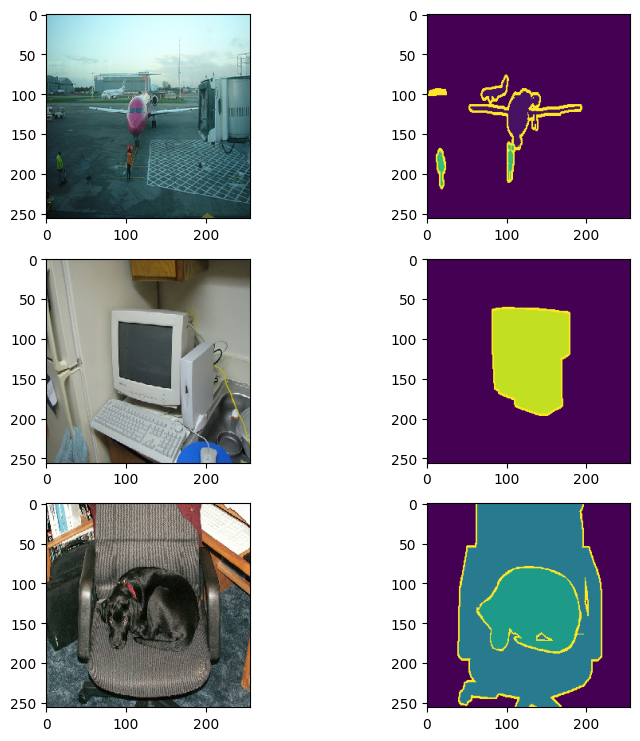

In [8]:
n_classes, img_size = 22, 256


def load_voc_dataset(split: tp.Literal["train", "val", "test"]):
    transforms = A.Compose(
        [
            A.Resize(img_size, img_size, interpolation=cv2.INTER_NEAREST),
            ToTensorV2(),
            A.Lambda(
                # Нормализуем изображение в отрезок [0, 1]
                image=lambda image, **_: image / 255.0,
                # Сделайте так, чтобы все классы шли друг от друга с шагом 1 (подумайте, что делать с классом 255)
                mask=lambda mask, **_: rework_mask(mask)
            ),
        ]
    )

    def rework_mask(mask):
        
        mask = np.array(mask)
        mask = mask.astype(np.int64)
        mask[mask == 255] = n_classes

        return torch.from_numpy(mask)

    def _transform(image, mask):
        # Конвертируем из PIL формата в np.array за счет np.array(image).
        # Заметьте, image=..., mask=... - это указание, что есть изображение и что есть маска.
        # Albumentations в общем виде по-разному обрабатывает изображения и маски.
        transformed = transforms(image=np.array(image), mask=np.array(mask))
        return transformed["image"], transformed["mask"]

    # Создание датасета с нужными трансформациями
    dataset = VOCSegmentation(
        root="./data",
        year="2012",
        image_set=split,
        download=not Path("./data").exists(),
        transforms=_transform,
    )
    return dataset


train_dataset = load_voc_dataset("train")
val_dataset = load_voc_dataset("val")
print(train_dataset[0])
print(train_dataset[0][0].shape, train_dataset[0][1].shape)

# Отрисовка изображения и маски
fig, ax = plt.subplots(3, 2, figsize=(9, 9))
for i in range(3):
    img, mask = train_dataset[i]
    ax[i][0].imshow(img.permute(1, 2, 0).numpy())
    ax[i][1].imshow(mask.numpy())
fig.show();

Теперь очередь за вами.
Обучите модель и сдайте её в ЛМС (инструкции выше).

Обратите внимание, что границы объекта выделены пикселем 255 - это немного выбивается из остальных классов, где метки идут с шагом 1 (0, 1, 2 и т.д. до 21).
Подумайте, как это исправить.

In [9]:
# Имплементация U-Net, взято из https://github.com/milesial/Pytorch-UNet
# Распространяется под лицензией GPL-3.0
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [10]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)

    def forward(self, x: torch.Tensor, x_left: torch.Tensor):
        x = self.up(x)
        # Западдим картинку снизу, если размерности отличаются
        diffY = x_left.shape[2] - x.shape[2]
        diffX = x_left.shape[3] - x.shape[3]

        x = F.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x_left, x], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor)
        self.up2 = Up(512, 256 // factor)
        self.up3 = Up(256, 128 // factor)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [17]:
from functools import reduce

import torch.nn as nn
import torch.nn.functional as F
import tqdm
import wandb
from torch.optim import Adam
n_steps_before_backward = 8

def calc_accuracy(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            pred_labels = torch.argmax(outputs, dim=1)
            correct += (pred_labels == labels).sum().item()
            total += labels.numel()
    model.train()
    return correct / total

# def calc_accuracy(model: nn.Module, loader: DataLoader, device: torch.device):
#     count_correct, count_total = 0, 0
#     model.eval()
#     for img_batch, true_labels in loader:
#         img_batch = img_batch.to(device)
#         true_labels = true_labels.to(device)
#         with torch.no_grad():
#             prediction = model(img_batch)
#         # (B, K, H, W)
#         # pred_labels = (prediction > 0).squeeze(1)
#         pred_labels = torch.argmax(prediction, dim=1)
#         count_correct += (pred_labels == true_labels).sum().item()
#         # произведение всех размерностей
#         count_total += reduce(lambda a, b: a * b, true_labels.shape, 1)
#     model.train()
#     return count_correct / count_total


def train_loop(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    device: torch.device,
):
    
    eval_every = 20
    optimizer = Adam(model.parameters(), lr=config.learning_rate)
    model.to(device)
    criterion = nn.CrossEntropyLoss(reduction="none", ignore_index=22)

    for epoch in range(config.epochs):
        print(f"Epoch #{epoch + 1}/#{config.epochs}")
        for i, (img_batch, true_labels) in enumerate(tqdm.tqdm(train_loader)):
            step = epoch * len(train_loader) + i
            img_batch, true_labels = img_batch.to(device), true_labels.to(device)
            
            pred_labels = model(img_batch).squeeze()
            loss = criterion(pred_labels, true_labels.long()).mean()
            loss.backward()

            # Будем не каждую итерацию делать шаг спуска.
            # Это увеличит batch_size без необходимости вмещать больше в память.
            if (step + 1) % n_steps_before_backward == 0:
                optimizer.step()
                optimizer.zero_grad()

            wandb.log({"loss": loss.item()}, step=step)
        #     if (i + 1) % eval_every == 0:
                # wandb.log(
                #     {"accuracy": calc_accuracy(model, val_loader, device)}, step=step
                # )
        wandb.log({"accuracy": calc_accuracy(model, val_loader, device)}, step=step)

In [12]:
from torch.utils.data import DataLoader, random_split

# # generator = torch.Generator().manual_seed(seed)
# train_dataset, val_dataset, test_dataset = random_split(
#     all_dataset, [0.8, 0.1, 0.1]
# )
train_loader = DataLoader(
    train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True
)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0, pin_memory=True, drop_last=True)
# test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

In [13]:
config

{'learning_rate': 0.001, 'architecture': 'U-Net', 'dataset': 'VOCSegmentation', 'batch_size': 8, 'epochs': 10, 'patience': 3, 'min_delta': 0.001}

In [14]:
model = UNet(3, n_classes).to(device)

In [15]:
img, mask = train_dataset[0]
print(img.shape, mask.shape)  # Например: (3, 256, 256), (256, 256)

for img_batch, mask_batch in train_loader:
    print(img_batch.shape, mask_batch.shape)  # Например: torch.Size([16, 3, 256, 256]), torch.Size([16, 256, 256])
    break

torch.Size([3, 256, 256]) torch.Size([256, 256])
torch.Size([8, 3, 256, 256]) torch.Size([8, 256, 256])


In [18]:
wandb.init(
    project="DL_course", 
    group="lesson_5",
    name="GPU_U-Net")
train_loop(model, train_loader, val_loader, device=device)

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch #1/#10


100%|██████████| 183/183 [01:44<00:00,  1.75it/s]


Epoch #2/#10


100%|██████████| 183/183 [01:50<00:00,  1.66it/s]


Epoch #3/#10


100%|██████████| 183/183 [01:50<00:00,  1.65it/s]


Epoch #4/#10


100%|██████████| 183/183 [01:51<00:00,  1.63it/s]


Epoch #5/#10


100%|██████████| 183/183 [01:42<00:00,  1.78it/s]


Epoch #6/#10


100%|██████████| 183/183 [01:42<00:00,  1.78it/s]


Epoch #7/#10


100%|██████████| 183/183 [01:46<00:00,  1.71it/s]


Epoch #8/#10


100%|██████████| 183/183 [01:48<00:00,  1.69it/s]


Epoch #9/#10


100%|██████████| 183/183 [01:45<00:00,  1.73it/s]


Epoch #10/#10


100%|██████████| 183/183 [01:43<00:00,  1.77it/s]


In [ ]:
@torch.inference_mode()
def visualize(model, batch, device):
    model.eval()
    xs, ys = batch
    for i, (x, y) in enumerate(zip(xs, ys)):
        prediction = model(x[None, ...].to(device)).cpu().squeeze(0).max(dim=0)[1]

        fig, ax = plt.subplots(1, 3, figsize=(24, 8), facecolor="white")

        ax[0].imshow(x.permute((1, 2, 0)))
        ax[1].imshow(y.to(torch.uint8))
        ax[2].imshow(prediction.to(torch.uint8))

        ax[0].axis("off")
        ax[1].axis("off")
        ax[2].axis("off")
        plt.subplots_adjust(wspace=0, hspace=0.1)
        plt.show()

        if i >= 9:
            break

In [ ]:
visualize(model, next(iter(val_loader)), device=device)

In [19]:
# model = ...
torch.save(model.state_dict(), "model.pt")

## GAN на MNIST

Во второй части задания мы попробуем генерировать изображения с цифрами.
Для этого возьмем модель GAN и обучим ее на датасет MNIST.

Ваша задача: скачайте датасет MNIST, обучите на нем GAN, сохраните веса генератора и дискриминатора в `generator.pt` и `discriminator.pt` соответственно.
Сдайте в ЛМС:
1. Код генератора и его веса.
2. Код дискриминатора и его веса.

In [3]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

In [13]:
batch_size = 256
# Используйте следующие параметры модели
image_size = 28
# Размер латентного вектора - из него генератор будет создавать изображение
nz = 100
nc = 3
# Размер feature map в генераторе
ngf = 64
# Размер feature map в дискриминаторе
ndf = 64
num_epochs = 10
lr = 0.0002
beta1 = 0.5

In [9]:
def load_df(split: bool):
    transforms = A.Compose([
        A.Resize(image_size, image_size),
        A.HorizontalFlip(p=0.5),
        A.CenterCrop(image_size, image_size),
        A.Normalize(mean=0.5, std=0.5),  # ✅ Для 1 канала
        ToTensorV2()
    ])

    def _transform(image):
        transformed = transforms(image=np.array(image))
        return transformed["image"]

    dataset = MNIST(
        root="./data2",
        train=split,
        download=not Path("./data2").exists(),
        transform=_transform  # ✅ Теперь передаётся как `transform`, а не `transforms`
    )
    return dataset

In [10]:
train_dataset = load_df(True)
test_dataset = load_df(False)

In [11]:
len(train_dataset)

60000

In [12]:
len(test_dataset)

10000

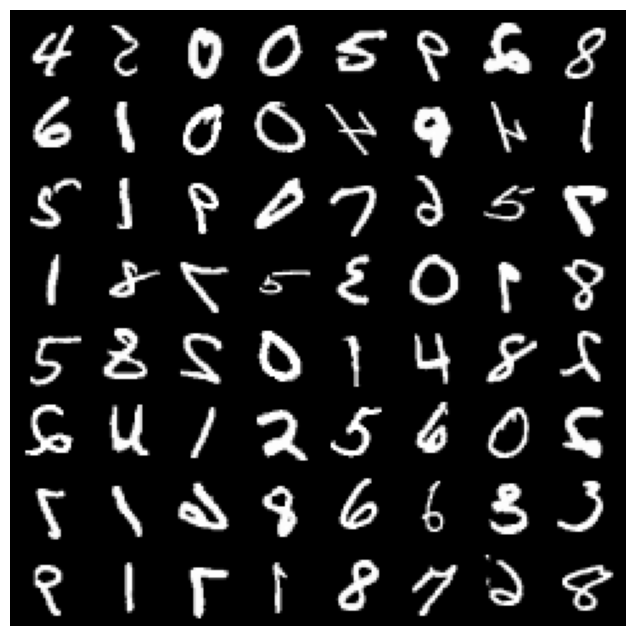

In [42]:
import torchvision.utils as vutils

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

real_batch = next(iter(train_loader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(
    np.transpose(
        vutils.make_grid(
            real_batch[0].to(device)[:64], padding=2, normalize=True
        ).cpu(),
        (1, 2, 0),
    )
)
plt.show()

In [16]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 784),  # 28x28 = 784
            nn.Tanh()  # [-1, 1] для выхода
        )

    def forward(self, x):
        return self.model(x).view(-1, 1, 28, 28)  # Формируем изображение 28x28

In [17]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Вероятность [0, 1]
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)

# Оптимизаторы
optimizer_G = optim.Adam(generator.parameters(), lr=config.learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

# Критерий потерь
criterion = nn.BCELoss()

In [ ]:
num_epochs = 10
wandb.init(project="GAN-MNIST", config={"epochs": num_epochs})

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        batch_size = real_images.shape[0]

        # ---------------------
        #  Обучаем дискриминатор
        # ---------------------
        optimizer_D.zero_grad()

        # Реальные изображения
        real_labels = torch.ones(batch_size, 1).to(device)
        real_output = discriminator(real_images)
        loss_real = criterion(real_output, real_labels)

        # Фейковые изображения
        z = torch.randn(batch_size, z_dim).to(device)
        fake_images = generator(z)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        fake_output = discriminator(fake_images.detach())
        loss_fake = criterion(fake_output, fake_labels)

        # Общий лосс дискриминатора
        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # ---------------------
        #  Обучаем генератор
        # ---------------------
        optimizer_G.zero_grad()

        # Генерируем новые изображения
        z = torch.randn(batch_size, z_dim).to(device)
        fake_images = generator(z)
        output = discriminator(fake_images)
        loss_G = criterion(output, torch.ones_like(output))  # Генератор хочет обмануть дискриминатор

        loss_G.backward()
        optimizer_G.step()

        # Логирование
        wandb.log({
            "loss_D": loss_D.item(),
            "loss_G": loss_G.item()
        })

    print(f"Epoch [{epoch+1}/{num_epochs}] | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")

In [7]:
# Используйте следующие параметры модели
image_size = 28
# Размер латентного вектора - из него генератор будет создавать изображение
nz = 100

## GAN с условиями

Наш GAN генерирует картинку из случайного класса.
Однако можно научить его принимать на вход метку класса и генерировать картинку с этой меткой.
Такие GAN называются **Conditional GAN** (*обусловленный GAN*).

Добавить обуславливание достаточно просто:
1. Добавьте в генератор embedding-слой для метки класса. Берите небольшую размерность вектора, 10-ти хватит.
2. Поменяйте первый ConvTranspose2d так, чтобы тот принял вектор длины 110 (100 от рандома, 10 от эмбеддинга).
3. Поменяйте код `forward` так, чтобы в ConvTranspose2d передавать объединенный вектор размера 110.
4. Сделайте аналогичные изменения в `Discriminator` - он тоже должен принимать `label` как аргумент в `forward` и учитывать его. Подумайте, какие слои и как надо будет поменять.

Сделайте **Conditional GAN**, обучите его.
Сдайте в ЛМС:
1. Новый код `Generator` и его веса.
2. Новый код `Discriminator` и его веса.

Если вы все сделали правильно, у вас должны получиться правдоподобные картинки для каждого из классов.